<a href="https://colab.research.google.com/github/hihunjin/Code-snippet-for-everything/blob/main/conv_bn_act_output_variance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!pip install timm

In [2]:
import torch
import timm

In [3]:
model = timm.create_model("resnet18")
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act1): ReLU(inplace=True)
      (aa): Identity()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, m

In [24]:
x = torch.rand(1, 3, 64, 64)

In [25]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook
model.layer1[1].conv2.register_forward_hook(get_activation('layer1_1_conv2'))
model.layer1[1].bn2.register_forward_hook(get_activation('layer1_1_bn2'))
model.layer1[1].act2.register_forward_hook(get_activation('layer1_1_act2'))

In [26]:
model(x);

## 결과
* bn2(BatchNorm2D)의 mean이 작아서 bn2의 Ou\tput과 act2의 Output이 같다.
  * bn2의 결과가 모두 양수이기 때문이다.

In [73]:
for layer_name in ["layer1_1_conv2", "layer1_1_bn2", "layer1_1_act2"]:
    print(layer_name)
    print("mean: ", activation[layer_name].mean())
    print("var : ", activation[layer_name].var())

layer1_1_conv2
mean:  tensor(0.0077)
var :  tensor(0.8560)
layer1_1_bn2
mean:  tensor(1.4006)
var :  tensor(0.3962)
layer1_1_act2
mean:  tensor(1.4006)
var :  tensor(0.3962)


In [70]:
model.layer1[1].bn2.running_mean.max(), model.layer1[1].bn2.running_var.mean()

(tensor(0.4709), tensor(0.8244))

In [57]:
model.layer1[1].conv2.weight.var()

tensor(0.0035, grad_fn=<VarBackward0>)

(array([2.000e+00, 5.000e+00, 8.000e+00, 1.800e+01, 4.000e+01, 8.600e+01,
        1.660e+02, 3.250e+02, 5.510e+02, 8.950e+02, 1.350e+03, 1.875e+03,
        2.521e+03, 3.090e+03, 3.569e+03, 3.799e+03, 3.792e+03, 3.571e+03,
        3.183e+03, 2.596e+03, 1.857e+03, 1.408e+03, 9.290e+02, 5.670e+02,
        3.290e+02, 1.690e+02, 8.300e+01, 4.700e+01, 2.000e+01, 1.300e+01]),
 array([-0.24808708, -0.23260975, -0.21713243, -0.2016551 , -0.18617778,
        -0.17070046, -0.15522313, -0.1397458 , -0.12426848, -0.10879115,
        -0.09331383, -0.07783651, -0.06235918, -0.04688185, -0.03140453,
        -0.0159272 , -0.00044988,  0.01502745,  0.03050477,  0.0459821 ,
         0.06145942,  0.07693674,  0.09241407,  0.1078914 ,  0.12336873,
         0.13884604,  0.15432337,  0.1698007 ,  0.18527803,  0.20075534,
         0.21623267], dtype=float32),
 <a list of 30 Patch objects>)

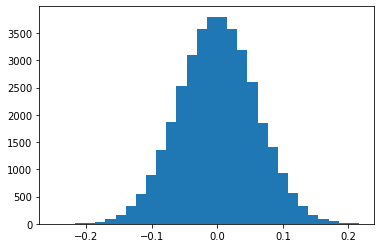

In [67]:
import matplotlib.pyplot as plt
plt.hist(model.layer1[1].conv2.weight.flatten().detach().numpy(), bins=30)